In [1]:
!pip3 install pyro-ppl

In [2]:
import pyro
import pyro.distributions as dist

import random

import numpy as np

import torch

In [3]:
torch.manual_seed(7)
pyro.set_rng_seed(7)
np.random.seed(7)

# Generate Dataset

In [4]:
class GMMSampler:

    def __init__(self, k, d, mu, sigma):
        self.k = k
        self.d = d

        assert mu.size() == (k, d), 'Input mu must be a tensor of size (%i, %i)' % (k, d)
        self.mu = mu

        assert sigma.size() == (k, d), 'Input sigma must be a tensor of size (%i, %i)' % (k, d)
        self.sigma = sigma

        self.init_gaussians()

    def init_gaussians(self):
        self.gaussians = [[dist.Normal(self.mu[k, d], self.sigma[k, d]) for d in range(self.d)] for k in range(self.k)]

    def sample(self, n):
        choices = np.random.choice(self.k, n, replace=True)
        samples = torch.zeros(n, self.d)

        for i, c in enumerate(choices):
            for d in range(self.d):
                component = self.gaussians[c][d] 
                samples[i, d] = component.sample()

        return samples

In [5]:
D = 2 

MU = torch.tensor([[-.5, -.5], [.5, .5]], dtype=torch.float)

SIGMA = torch.tensor([[.1, .1], [.1, .1]], dtype=torch.float)

In [6]:
bimodal_sampler = GMMSampler(2, D, MU, SIGMA)

In [7]:
N = 10000

data = bimodal_sampler.sample(N)

data

tensor([[ 0.4853,  0.5786],
        [-0.4053, -0.6114],
        [ 0.6691,  0.4105],
        ...,
        [-0.5626, -0.4309],
        [ 0.6926,  0.3709],
        [-0.5814, -0.5113]])

In [8]:
import matplotlib.pyplot as plt

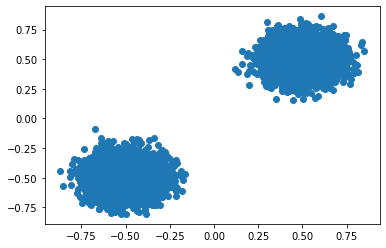

In [9]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [10]:
def split_train_test(data, ratio=0.8):

    N = data.shape[0]
    indices = torch.randperm(N)

    N_train = int(N * ratio)

    train_indices = indices[:N_train]
    test_indices = indices[N_train:]

    data_train = data[train_indices]
    data_test = data[test_indices]

    return data_train, data_test

In [11]:
data_train, data_test = split_train_test(data)

# 2. Define the Pyro Model

In [12]:
from pyro.infer import config_enumerate

from torch.distributions import constraints

In [13]:
K = 2 # number of components

def model(data):

    N = data.shape[0] # number of samples
    D = 1 if len(data.shape) == 1 else data.shape[1] # data dimensionality

    # Global variables as initialized in the paper with Stan 

    # Component weights
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(K) / K))

    # Locs and scales of the components
    with pyro.plate('dimensions', D):
        with pyro.plate('components', K):
            mu = pyro.sample('mu', dist.Normal(torch.tensor([0.]), torch.tensor([1.])))
            sigma = pyro.sample('sigma', dist.LogNormal(torch.tensor([0.]), torch.tensor([1])))

    with pyro.plate('data', N):
        assignment = pyro.sample('assignment', dist.Categorical(theta), infer={'enumerate': 'parallel'})
        pyro.sample('obs', dist.Normal(mu[assignment], sigma[assignment]).to_event(1), obs=data)

# Run ADVI

In [14]:
import torch.nn as nn

import pandas as pd

from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal

import time

from tqdm.notebook import trange

In [15]:
from pyro.infer.autoguide.initialization import init_to_sample, init_to_uniform, init_to_value

init_values = {
    'mu': torch.mean(data_train, dim=0).expand(K, D), 
    'sigma': torch.std(data_train, dim=0).expand(K, D), 
    'theta': torch.ones(K) / K
    }

def run_advi(model, num_iter, num_particles, verbose=False, lr=0.005):
    guide = AutoDiagonalNormal(poutine.block(model, expose=['theta', 'mu', 'sigma']), init_loc_fn=init_to_value(values=init_values, fallback=init_to_sample))
    #guide = AutoDiagonalNormal(poutine.block(model, expose=['theta', 'mu', 'sigma']))
    adaprop = pyro.optim.AdagradRMSProp(dict())

    adam_params = {"lr": lr, "betas": (0.95, 0.999)}
    optimizer = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(num_particles=num_particles)) # NOTE: TraceEnum_ELBO is crucial

    pyro.clear_param_store()

    output_advi = pd.DataFrame(columns = ['t', 'test_accuracy', 'model'])

    train_time = 0

    mse_loss = nn.MSELoss()

    for j in trange(num_iter):
        t0 = time.time()
        loss = svi.step(data_train)
        train_time += time.time() - t0
    
        if j % 100 == 0:
            learned_theta = guide.median()['theta']
            learned_mu = guide.median()['mu']
            learned_sigma = guide.median()['sigma']

            #print(learned_theta, learned_mu, learned_sigma) # DEBUG
            
            # Compute Likelihood as in the paper
            test_log_prob = 0
            for n in range(data_test.shape[0]):
                ps = torch.zeros(K, 1)
                for k in range(K):
                    learned_normal = dist.Normal(learned_mu[k], learned_sigma[k])
                    ps[k] = torch.log(learned_theta[k]) + learned_normal.log_prob(data_test[n]).sum()
                test_log_prob += torch.logsumexp(ps.flatten(), dim=-1)

            output_iter = {'t': train_time,
                           'test_accuracy': test_log_prob.detach().numpy(),
                           'model': 'advi{}'.format(num_particles)}
            output_advi = output_advi.append(output_iter, ignore_index=True)
            
            if verbose: 
                print('[iteration %04d] test_accuracy: %.4f' % (j + 1, test_log_prob))  

    return output_advi

In [16]:
# Train the ADVI models
print('Running ADVI with M=1')
output_advi_M1 = run_advi(model, 1000, 1, True)

#print('Running ADVI with M=10')
#output_advi_M10 = run_advi(model, 1000, 10, True)

Running ADVI with M=1


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2993.2598
[iteration 0101] test_accuracy: -2552.5007
[iteration 0201] test_accuracy: 439.1738
[iteration 0301] test_accuracy: 1768.6445
[iteration 0401] test_accuracy: 2100.7375
[iteration 0501] test_accuracy: 2123.9468
[iteration 0601] test_accuracy: 2119.0300
[iteration 0701] test_accuracy: 2119.5503
[iteration 0801] test_accuracy: 2119.9189
[iteration 0901] test_accuracy: 2110.4800


In [17]:
output_advi_M1

,t,test_accuracy,model
0,0.079013,-2993.2598,advi1
1,1.994073,-2552.5007,advi1
2,4.826792,439.17377,advi1
3,8.761992,1768.6445,advi1
4,13.118004,2100.7375,advi1
5,17.425377,2123.9468,advi1
6,22.086995,2119.03,advi1
7,24.271404,2119.5503,advi1
8,26.465523,2119.919,advi1
9,28.624585,2110.48,advi1


In [18]:
#output_advi_M10

# Run NUTS


In [19]:
from pyro.infer import MCMC, NUTS, HMC

import torch.distributions.transforms as transforms

In [20]:
def run_mcmc(model, num_samples, num_warmups, kernel_method):
    pyro.clear_param_store()

    test_log_prob_arr = []
    train_time = []

    def hook_fn(kernel, sample, stage, i):
        # Use the most recently sampled param to estimate performance
        if i < 100 or (i % 10 == 0): # Evaluate all first 100 samples and then every 50
            learned_theta = transforms.StickBreakingTransform()(sample['theta']) # # NOTE: StickBreakingTransform is crucial
            learned_mu = sample['mu']
            learned_sigma = torch.exp(sample['sigma'])

            #print(learned_theta) # DEBUG

            # Compute Likelihood as in the paper
            test_log_prob = 0
            for n in range(data_test.shape[0]):
                ps = torch.zeros(K, 1)
                for k in range(K):
                    learned_normal = dist.Normal(learned_mu[k], learned_sigma[k])
                    ps[k] = torch.log(learned_theta[k]) + learned_normal.log_prob(data_test[n]).sum()
                test_log_prob += torch.logsumexp(ps.flatten(), dim=-1)

            train_time.append(time.time())    
            test_log_prob_arr.append(test_log_prob)

    if kernel_method == 'NUTS':
        kernel = NUTS(model,max_tree_depth=4)
    elif kernel_method == 'HMC':
        kernel = HMC(model,
                     step_size=0.1, 
                     num_steps=10, 
                     target_accept_prob=0.8,
                     adapt_step_size = False)
    else:
        raise Exception('Unknown Kernel Method.')

    nuts = MCMC(kernel,
                num_samples=num_samples,
                warmup_steps=num_warmups,
                disable_progbar=False,
                num_chains=1,
                hook_fn=hook_fn) 

    nuts.run(data_train)

    output_mcmc = pd.DataFrame({'t': np.array(train_time) - train_time[0], 
                                'test_accuracy': np.array(test_log_prob_arr),
                                'model': kernel_method})
    
    return output_mcmc

In [21]:
# Train the MCMC models 
print('Running MCMC with NUTS kernel')
output_nuts = run_mcmc(model, 100, 100, 'NUTS')

# Does not produce any meaningful result
#print('Running MCMC with HMC kernel')
#output_hmc = run_mcmc(model, 2000, 2000, 'HMC')

Running MCMC with NUTS kernel


Sample: 100%|██████████| 200/200 [01:48,  1.84it/s, step size=1.10e-02, acc. prob=0.805]


In [22]:
output_nuts

,t,test_accuracy,model
0,0.000000,-5835.726074,NUTS
1,0.449336,-5835.726074,NUTS
2,0.884028,-5835.726074,NUTS
3,1.329335,-5728.889160,NUTS
4,1.844203,-3932.447754,NUTS
...,...,...,...
195,105.741251,2121.567871,NUTS
196,106.257502,2123.175537,NUTS
197,106.905310,2124.542236,NUTS
198,107.451065,2124.165527,NUTS


In [23]:
import seaborn as sns

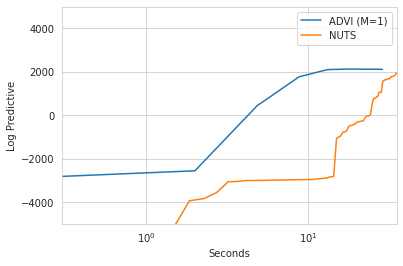

In [24]:
# Generate plot
output = output_advi_M1#.append(output_advi_M10, ignore_index=True)
output = output.append(output_nuts, ignore_index=True)
#output = output.append(output_hmc, ignore_index=True)
output['test_accuracy'] = output['test_accuracy'].astype('float')

sns.set_style('whitegrid')
results1 = sns.lineplot(data=output, x='t', y='test_accuracy', hue='model')
results1.set(xscale='log', 
            xlim=(0.3, 35), 
            ylim=(-5000, 5000),
            xlabel='Seconds',
            ylabel='Log Predictive')
plt.legend(labels=['ADVI (M=1)', 'NUTS']) #, 'HMC'])

## Model Misspecification

The experiment goes as follows:

- We initialize a model with 5 posterior modes (K), a 5-component Gaussian Mixture Model. 
- We sample from this model and generate a synthetic dataset.
- We assume we correctly specify the model and run ADVI and NUTS with K = 5.
- We assume we misspesify the model and run ADVI and NUTS with K = 3.

In [25]:
# Initialize and sample from the 5-component gaussian
five_modal_sampler = GMMSampler(5, 
                                2, 
                                torch.tensor([[-.5, -.5], [.5, .5], [-.5, .5], [.5, -.5], [0, 0]], dtype=torch.float), 
                                torch.tensor([[.1, .1], [.1, .1], [.1, .1], [.1, .1], [.1, .1]], dtype=torch.float))

data5 = five_modal_sampler.sample(N)

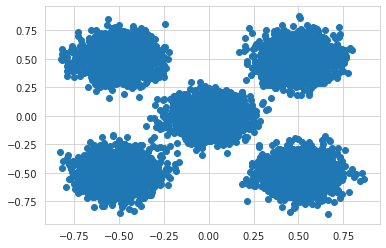

In [26]:
plt.scatter(data5[:, 0], data5[:, 1])
plt.show()

In [27]:
data_train, data_test = split_train_test(data5)

In [28]:
# Assume correct specification
K = 5
init_values = {
    'mu': torch.mean(data_train, dim=0).expand(K, D), 
    'sigma': torch.std(data_train, dim=0).expand(K, D), 
    'theta': torch.ones(K) / K
    }

# Train the ADVI model
print('Running ADVI with M=1 and K=5')
output_advi_M1_K5_correct = run_advi(model, 1000, 1, True, lr=0.05)

print('Running MCMC with NUTS kernel, K=5')
output_nuts_K5_correct = run_mcmc(model, 100, 100, 'NUTS')

Running ADVI with M=1 and K=5


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2591.2876
[iteration 0101] test_accuracy: -1543.2026
[iteration 0201] test_accuracy: -242.5278
[iteration 0301] test_accuracy: 255.7017
[iteration 0401] test_accuracy: 257.9966
[iteration 0501] test_accuracy: 257.8758
[iteration 0601] test_accuracy: 261.8098
[iteration 0701] test_accuracy: 259.6613
[iteration 0801] test_accuracy: 263.8184
[iteration 0901] test_accuracy: 257.0930
Running MCMC with NUTS kernel, K=5


Sample: 100%|██████████| 200/200 [04:15,  1.28s/it, step size=4.91e-01, acc. prob=0.897]


In [29]:
# Assume misspecification
K = 3
init_values = {
    'mu': torch.mean(data_train, dim=0).expand(K, D), 
    'sigma': torch.std(data_train, dim=0).expand(K, D), 
    'theta': torch.ones(K) / K
    }

# Train the ADVI model
print('Running ADVI with M=1 and false K=3')
output_advi_M1_K3_false = run_advi(model, 1000, 1, True, lr=0.05)

print('Running MCMC with NUTS kernel, false K=3')
output_nuts_K3_false = run_mcmc(model, 100, 100, 'NUTS')

Running ADVI with M=1 and false K=3


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2571.0850
[iteration 0101] test_accuracy: -1303.9572
[iteration 0201] test_accuracy: -1199.9711
[iteration 0301] test_accuracy: -1206.2797
[iteration 0401] test_accuracy: -1200.2052
[iteration 0501] test_accuracy: -1198.4490
[iteration 0601] test_accuracy: -1203.1976
[iteration 0701] test_accuracy: -1201.7308
[iteration 0801] test_accuracy: -1203.7573
[iteration 0901] test_accuracy: -1197.9816
Running MCMC with NUTS kernel, false K=3


Sample: 100%|██████████| 200/200 [02:42,  1.23it/s, step size=9.48e-03, acc. prob=0.958]


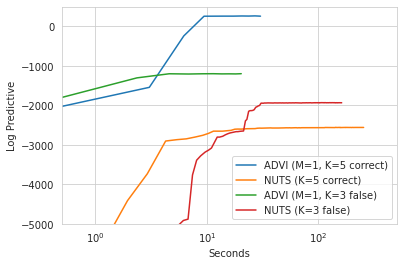

In [30]:
# Generate plot
output_advi_M1_K5_correct['test_accuracy'] = output_advi_M1_K5_correct['test_accuracy'].astype('float')
output_advi_M1_K3_false['test_accuracy'] = output_advi_M1_K3_false['test_accuracy'].astype('float')

sns.set_style('whitegrid')

results2 = sns.lineplot(data=output_advi_M1_K5_correct, x='t', y='test_accuracy')
results2 = sns.lineplot(data=output_nuts_K5_correct, x='t', y='test_accuracy')

results2 = sns.lineplot(data=output_advi_M1_K3_false, x='t', y='test_accuracy')
results2 = sns.lineplot(data=output_nuts_K3_false, x='t', y='test_accuracy')

results2.set(xscale='log', 
            xlim=(0.5, 500), 
            ylim=(-5000, 500),
            xlabel='Seconds',
            ylabel='Log Predictive')
plt.legend(labels=['ADVI (M=1, K=5 correct)',
                   'NUTS (K=5 correct)',
                   'ADVI (M=1, K=3 false)', 
                   'NUTS (K=3 false)'])

In [31]:
# Uncomment if you want to download the plots as PDFs
from google.colab import files

fig1 = results1.get_figure()
fig1.savefig('GMMTime.pdf')
files.download('GMMTime.pdf') 

fig2 = results2.get_figure()
fig2.savefig('GMMK.pdf')
files.download('GMMK.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>